In [9]:
# If external python files are updated
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import numpy as np
import os

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score

import torch.nn.init as init
from torch.optim import lr_scheduler

import functions
from functions import Custom_DNN, EarlyStopper

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device used: cpu


In [2]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# train_size = 0.75                     # In percent
train_size = 0.1                     # In percent
test_size = 1 - train_size           # In percent, calculated dynamically from train_size
batch_size = 16                      # Size of batches

In [4]:
# Create an empty array to store the image arrays and class
X = []
Y = []

# Define the folder paths containing the images
folder_paths = ['Dataset/Non_Demented/', 'Dataset/Very_Mild_Demented/', 'Dataset/Mild_Demented/', 'Dataset/Moderate_Demented/']
classes = [r'Non demented', r'Very mildly demented', r'mild demented', r'moderate demented']

# Loop over the images to save them in the list
for path in folder_paths:
    c = folder_paths.index(path)
    items = os.listdir(path)
    for picture in items:
        file_path = os.path.join(path, picture)
        # Open the image and convert it to a NumPy array
        img = Image.open(file_path)
        array_representation = np.asarray(img)

        # Append the NumPy array to the list
        X.append(array_representation)
        Y.append(c)

# Convert the list of image arrays to a NumPy arrayF
X = np.array(X)

from sklearn.preprocessing import Normalizer

# Transpose to make each image a row
X = X.reshape(X.shape[0], -1)

# Normalize each row (i.e., each flattened image)
X = Normalizer().fit_transform(X)
X = X.reshape(len(X), 128**2)

# Dynamically calculate the number of classes in dataset
num_classes = len(np.unique(Y))

# Shape of the array
print(np.shape(X))

(6400, 16384)


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1 - train_size, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 1 - train_size, stratify=Y_train, random_state=42)

for i in np.unique(Y_train):
    print(f"Elements of {i} in X_train: {np.count_nonzero(Y_train == i)}")
print()
for i in np.unique(Y_test):
    print(f"Elements of {i} in X_test: {np.count_nonzero(Y_test == i)}")
print()
for i in np.unique(Y_val):
    print(f"Elements of {i} in X_val: {np.count_nonzero(Y_val == i)}")

Elements of 0 in X_train: 32
Elements of 1 in X_train: 22
Elements of 2 in X_train: 9
Elements of 3 in X_train: 1

Elements of 0 in X_test: 2880
Elements of 1 in X_test: 2016
Elements of 2 in X_test: 806
Elements of 3 in X_test: 58

Elements of 0 in X_val: 288
Elements of 1 in X_val: 202
Elements of 2 in X_val: 81
Elements of 3 in X_val: 5


In [6]:
from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
from torchvision.transforms import v2

# Assuming you have a class named MyDataset for your dataset
class MyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data_point = self.X[idx]
        label = self.Y[idx]

        if self.transform:
            data_point = self.transform(data_point)
        
        data_point = torch.tensor(data_point, dtype=torch.float32)

        return data_point, label

# # Define transformations, you can adjust these based on your needs
# transformation = transforms.Compose([
#     transforms.ToTensor(),  # Converts to PyTorch tensor
# ])

transformation = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
])

# Create an instance of your dataset
dataset_train = MyDataset(X=X_train, Y=Y_train, transform=transformation)
dataset_val = MyDataset(X=X_val, Y=Y_val, transform=transformation)
dataset_test = MyDataset(X=X_test, Y=Y_test, transform=transformation)

# Define DataLoader for training, validation and test sets
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Dynamic DNN creation

In [8]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        init.zeros_(m.bias)

# Hyperparameters
epochs = 20
dropout_rate = 0.2

dynamic_model = Custom_DNN(input_size=128**2, initial_nodes=1024, output_size=4, n_layers=7, operation_and_factor= ('/', 2), dropout_rate=dropout_rate)
dynamic_model.apply(init_weights)

early_stopper = EarlyStopper(dynamic_model, patience=3, min_delta=0.2)
optimizer = torch.optim.Adam(dynamic_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()


loss_training_hist, loss_val_hist, training_acc_hist, val_acc_hist = functions.train_network(dynamic_model, train_loader, criterion, optimizer, epochs, scheduler, validation_loader, device, early_stopper)

Size last layer before output: 32
Device used for training: cpu
Epoch [1/20], Step [37/225], Loss: 1.1192
Epoch [1/20], Step [74/225], Loss: 0.9786
Epoch [1/20], Step [111/225], Loss: 1.1306
Epoch [1/20], Step [148/225], Loss: 0.9945
Epoch [1/20], Step [185/225], Loss: 1.0194
Epoch [1/20], Step [222/225], Loss: 0.9906
Epoch [2/20], Step [37/225], Loss: 1.0089
Epoch [2/20], Step [74/225], Loss: 1.0146
Epoch [2/20], Step [111/225], Loss: 1.0677
Epoch [2/20], Step [148/225], Loss: 1.0938
Epoch [2/20], Step [185/225], Loss: 1.0174
Epoch [2/20], Step [222/225], Loss: 1.0022
Epoch [3/20], Step [37/225], Loss: 0.9626
Epoch [3/20], Step [74/225], Loss: 1.0707
Epoch [3/20], Step [111/225], Loss: 0.9045
Epoch [3/20], Step [148/225], Loss: 0.9879
Epoch [3/20], Step [185/225], Loss: 0.9565
Epoch [3/20], Step [222/225], Loss: 1.0167
Epoch [4/20], Step [37/225], Loss: 0.8788
Epoch [4/20], Step [74/225], Loss: 1.1038
Epoch [4/20], Step [111/225], Loss: 0.8917
Epoch [4/20], Step [148/225], Loss: 1.100

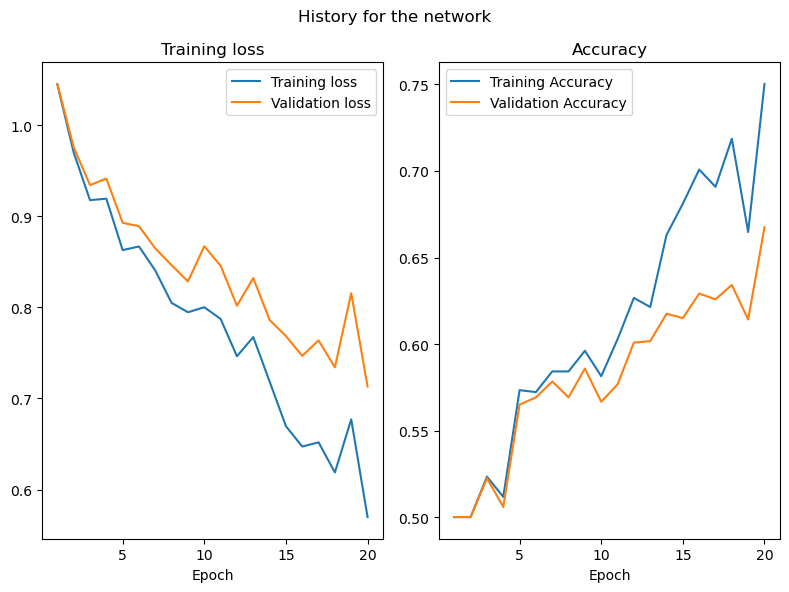

In [9]:
x_epochs = np.linspace(1, len(loss_training_hist), len(loss_training_hist))
fig, ax = plt.subplots(1, 2, figsize=(8,6))
ax[0].plot(x_epochs, loss_training_hist, label = 'Training loss')
ax[0].plot(x_epochs, loss_val_hist, label = 'Validation loss')
ax[0].set(
    xlabel='Epoch',
    title='Training loss'
)

ax[1].plot(x_epochs, training_acc_hist, label='Training Accuracy')
ax[1].plot(x_epochs, val_acc_hist, label='Validation Accuracy')
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)

fig.suptitle('History for the network')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

# Hyperparameter search

In [20]:
from itertools import product
params_to_test = ({
    'num_dense_layers' : [4, 10],
    'num_dense_nodes' : [2048, 8192],
    'factor' : [2, 6]
})

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        init.zeros_(m.bias)

# Hyperparameters
epochs = 1
dropout_rate = 0.2
        
# Generate all combinations of hyperparameters
hyperparameter_combinations = list(product(*params_to_test.values()))
criterion = nn.CrossEntropyLoss()

# Define lists to store the histories and the corresponding parameters in
hist_loss_params = {}

# Print the generated combinations
for i, combination in enumerate(hyperparameter_combinations):
    # Get parameters
    params = dict(zip(params_to_test.keys(), combination))
    # Define model
    test_model = Custom_DNN(128**2, params['num_dense_nodes'], num_classes, params['num_dense_layers'], ('/', params['factor']), dropout_rate=0.2)
    # Setup
    early_stopper = EarlyStopper(test_model, patience=3, min_delta=0.2)
    optimizer = torch.optim.Adam(test_model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    # Training
    loss_training_hist, loss_val_hist, training_acc_hist, val_acc_hist = functions.train_network(test_model, train_loader, criterion, optimizer, epochs, scheduler, validation_loader, device, early_stopper)

    # Store the hists etc
    hist_loss_params[tuple(params.items())] = (loss_training_hist, loss_val_hist, training_acc_hist, val_acc_hist)


Size last layer before output: 512
Device used for training: cpu
Epoch [1/1], Step [2/4], Loss: 1.3306
Epoch [1/1], Step [4/4], Loss: 1.2044
Size last layer before output: 56
Device used for training: cpu
Epoch [1/1], Step [2/4], Loss: 1.3237
Epoch [1/1], Step [4/4], Loss: 1.2993
Size last layer before output: 2048
Device used for training: cpu
Epoch [1/1], Step [2/4], Loss: 1.1986
Epoch [1/1], Step [4/4], Loss: 1.8618
Size last layer before output: 227
Device used for training: cpu
Epoch [1/1], Step [2/4], Loss: 1.2974
Epoch [1/1], Step [4/4], Loss: 1.1290
Size last layer before output: 8
Device used for training: cpu
Epoch [1/1], Step [2/4], Loss: 1.2976
Epoch [1/1], Step [4/4], Loss: 1.3259


/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Size last layer before output: 0
Device used for training: cpu
Epoch [1/1], Step [2/4], Loss: 1.3855
Epoch [1/1], Step [4/4], Loss: 1.3845
Size last layer before output: 32
Device used for training: cpu
Epoch [1/1], Step [2/4], Loss: 1.4592
Epoch [1/1], Step [4/4], Loss: 1.3645


/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Size last layer before output: 0
Device used for training: cpu
Epoch [1/1], Step [2/4], Loss: 1.3859
Epoch [1/1], Step [4/4], Loss: 1.3839
